In [ ]:
### Phase 1....

In [8]:
import pandas as pd
import numpy as np
import re
import unicodedata
import time
import os  # Added for directory management
from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Start execution timer
start_time = time.time()

# 1.1 Database Extraction
print("Step 1.1: Establishing Database Connection and Extracting Records...")
engine = create_engine('mysql+mysqlconnector://root:@localhost:3306/drugbank')

with tqdm(total=5, desc="Extracting Tables") as pbar:
    drug_df = pd.read_sql("SELECT drug_pk, primary_drugbank_id, state, half_life, toxicity FROM drug", engine)
    pbar.update(1)
    
    interaction_query = """
        SELECT i.drug_pk, ip.polypeptide_id AS interactant_id 
        FROM interactant i 
        JOIN interactant_polypeptide ip ON i.interactant_pk = ip.interactant_pk 
        WHERE i.kind='target'
    """
    interaction_df = pd.read_sql(interaction_query, engine)
    pbar.update(1)
    
    target_df = pd.read_sql("SELECT polypeptide_id, organism_name, molecular_weight FROM polypeptide", engine)
    pbar.update(1)
    
    properties_df = pd.read_sql("SELECT drug_pk, kind, value FROM drug_property WHERE property_type='calculated'", engine)
    pbar.update(1)
    
    category_df = pd.read_sql("SELECT drug_pk, category FROM drug_category", engine)
    pbar.update(1)

# 1.2 Entity Resolution & Pivot
print("\nStep 1.2: Standardizing IDs and Aggregating Properties...")
drug_df['primary_drugbank_id'] = drug_df['primary_drugbank_id'].str.upper().str.strip()
drug_df.drop_duplicates(subset=['drug_pk'], inplace=True)

properties_pivot = properties_df.pivot_table(
    index='drug_pk', columns='kind', values='value', aggfunc='first'
).reset_index()

prop_cols = properties_pivot.columns.drop('drug_pk')
properties_pivot[prop_cols] = properties_pivot[prop_cols].apply(pd.to_numeric, errors='coerce')
properties_pivot = properties_pivot.dropna(axis=1, how='all')

drug_features = pd.merge(drug_df, properties_pivot, on='drug_pk', how='left')

# 1.3 Data Cleaning & Normalization
print("\nStep 1.3: Normalizing Text and Parsing...")
def parse_range(text):
    if pd.isna(text): return np.nan
    nums = re.findall(r'\d+\.?\d*', str(text))
    return np.mean([float(n) for n in nums]) if nums else np.nan

drug_features['half_life_avg'] = drug_features['half_life'].apply(parse_range)
target_df['molecular_weight'] = target_df['molecular_weight'].apply(parse_range)

def full_norm(text):
    if not isinstance(text, str): return text
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii').lower().strip()

cat_cols = drug_features.select_dtypes(include=['object', 'string']).columns
for col in tqdm(cat_cols, desc="Normalizing Categorical Text"):
    drug_features[col] = drug_features[col].apply(full_norm)

# 1.4 Imputation and Encoding
print("\nStep 1.4: Handling Missing Values and Encoding...")
cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
drug_features[cat_cols] = cat_imputer.fit_transform(drug_features[cat_cols])

num_cols = drug_features.select_dtypes(include=[np.number]).columns
valid_num_cols = [c for c in num_cols if drug_features[c].notna().any()]

if len(valid_num_cols) > 0:
    num_imputer = SimpleImputer(strategy='median')
    drug_features[valid_num_cols] = num_imputer.fit_transform(drug_features[valid_num_cols])

if 'state' in drug_features.columns:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_state = encoder.fit_transform(drug_features[['state']])
    encoded_state_df = pd.DataFrame(encoded_state, columns=encoder.get_feature_names_out(['state']))
    drug_features = pd.concat([drug_features.drop('state', axis=1), encoded_state_df], axis=1)

# 1.5 DTI Dataset Construction
print("\nStep 1.5: Constructing DTI Dataset...")
positives = interaction_df[['drug_pk', 'interactant_id']].copy()
positives['target_label'] = 1

all_drugs = drug_features['drug_pk'].unique()
all_targets = target_df['polypeptide_id'].unique()
pos_set = set(zip(positives['drug_pk'], positives['interactant_id']))

negs = []
with tqdm(total=len(positives), desc="Sampling Negatives") as pbar:
    while len(negs) < len(positives):
        d, t = np.random.choice(all_drugs), np.random.choice(all_targets)
        if (d, t) not in pos_set:
            negs.append([d, t, 0])
            pbar.update(1)

final_df = pd.concat([positives, pd.DataFrame(negs, columns=['drug_pk', 'interactant_id', 'target_label'])]).drop_duplicates()
final_df = final_df.merge(drug_features, on='drug_pk', how='left')
final_df = final_df.merge(target_df, left_on='interactant_id', right_on='polypeptide_id', how='left')

# SAVING LOGIC: Create directory if it does not exist
output_dir = "out/phase-1"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

file_path = os.path.join(output_dir, "final_preprocessed_dti.csv")
final_df.to_csv(file_path, index=False)

end_time = time.time()
print(f"\nExecution Complete. Saved to: {file_path}")
print(f"Total Rows Generated: {len(final_df)}")
print(f"Total Execution Time: {end_time - start_time:.2f} seconds")

Step 1.1: Establishing Database Connection and Extracting Records...



Extracting Tables: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]



Step 1.2: Standardizing IDs and Aggregating Properties...

Step 1.3: Normalizing Text and Parsing...



Normalizing Categorical Text: 100%|██████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.23it/s]



Step 1.4: Handling Missing Values and Encoding...

Step 1.5: Constructing DTI Dataset...



Sampling Negatives: 100%|█████████████████████████████████████████████████████| 26245/26245 [00:02<00:00, 12264.59it/s]


Created directory: out/phase-1

Execution Complete. Saved to: out/phase-1\final_preprocessed_dti.csv
Total Rows Generated: 51912
Total Execution Time: 18.00 seconds


In [ ]:
### Phase - 2

In [20]:
import pandas as pd
import numpy as np
import time
import os
import re
import unicodedata
import networkx as nx
from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Start execution timer
phase2_start_time = time.time()

# 1. Configuration and Loading
input_file = "./out/phase-1/final_preprocessed_dti.csv"
output_dir = "./out/phase-2"
os.makedirs(output_dir, exist_ok=True)

print("Step 2.1: Loading Phase 1 Data and Synchronizing with Database...")
df = pd.read_csv(input_file)
engine = create_engine('mysql+mysqlconnector://root:@localhost:3306/drugbank')

# 2.1 Multi-Source Feature Extraction
with tqdm(total=5, desc="Extracting Database Tables") as pbar:
    mech_df = pd.read_sql("SELECT drug_pk, mechanism_of_action FROM drug", engine)
    pbar.update(1)
    class_df = pd.read_sql("SELECT drug_pk, kingdom, superclass FROM drug_classification", engine)
    pbar.update(1)
    # Pathway counts for drugs and targets
    pathway_counts = pd.read_sql("""
        SELECT drug_pk, COUNT(smpdb_id) as p_count 
        FROM drug_pathway GROUP BY drug_pk""", engine)
    pbar.update(1)
    pathway_feat = pd.read_sql("""
        SELECT dp.drug_pk, p.category 
        FROM drug_pathway dp 
        JOIN pathway p ON dp.smpdb_id = p.smpdb_id""", engine)
    pbar.update(1)
    smiles_df = pd.read_sql("SELECT drug_pk, value as smiles FROM drug_property WHERE kind='SMILES'", engine)
    pbar.update(1)

# Merge Drug-level metadata
df = df.merge(mech_df, on='drug_pk', how='left')
df = df.merge(class_df, on='drug_pk', how='left')
# Map pathway counts to the drug side
df['drug_pathway_count'] = df['drug_pk'].map(pathway_counts.set_index('drug_pk')['p_count']).fillna(0)
# Map pathway counts to the target side (interactant_id)
df['target_pathway_count'] = df['interactant_id'].map(pathway_counts.set_index('drug_pk')['p_count']).fillna(0)

# One-Hot Encoding for Classifications & Pathway Categories
df = pd.get_dummies(df, columns=['kingdom', 'superclass'], prefix='cls', dummy_na=False)
path_cat_dummies = pd.get_dummies(pathway_feat, columns=['category'], prefix='path').groupby('drug_pk').sum()
df = df.merge(path_cat_dummies, on='drug_pk', how='left').fillna(0)

# 2.2 Advanced Pairwise Composition
print("\nStep 2.2: Computing Pairwise Difference and Product Features...")
# Fixed logic: Using specific drug/target columns
df['diff_pathway'] = abs(df['drug_pathway_count'] - df['target_pathway_count'])
df['prod_pathway'] = df['drug_pathway_count'] * df['target_pathway_count']

# 2.3 Network Centrality & Frequency
print("\nStep 2.3: Computing Weighted Network Metrics...")
G = nx.from_pandas_edgelist(df[df['target_label'] == 1], 'drug_pk', 'interactant_id')
betweenness = nx.betweenness_centrality(G, k=min(100, len(G.nodes())))
df['drug_betweenness'] = df['drug_pk'].map(betweenness).fillna(0)
df['target_betweenness'] = df['interactant_id'].map(betweenness).fillna(0)

# 2.4 Importance Selection & PCA
print("\nStep 2.4: Feature Importance Gating and PCA...")
tfidf = TfidfVectorizer(max_features=30, stop_words='english')
mech_tfidf = tfidf.fit_transform(df['mechanism_of_action'].astype(str).fillna('')).toarray()
mech_feat_df = pd.DataFrame(mech_tfidf, columns=[f"tfidf_{i}" for i in range(30)])

num_cols = df.select_dtypes(include=[np.number]).columns.drop(['drug_pk', 'target_label'])
X_all = pd.concat([df[num_cols].reset_index(drop=True), mech_feat_df], axis=1).fillna(0)
y = df['target_label']

rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_all, y)

X_final = PCA(n_components=0.95).fit_transform(StandardScaler().fit_transform(X_all))
pca_df = pd.DataFrame(X_final)

# Step 4: Conditional Balancing
print("\nStep 4: Checking Data Balance...")
counts = y.value_counts()
if (min(counts) / max(counts)) < 0.3:
    sampler = SMOTE(random_state=42) if counts[0] > counts[1] else RandomUnderSampler(random_state=42)
    X_res, y_res = sampler.fit_resample(pca_df, y)
else:
    X_res, y_res = pca_df, y

# Final Re-attachment of IDs for Phase 4
final_df = pd.concat([X_res, y_res.reset_index(drop=True)], axis=1)
# Preserving IDs from the original DataFrame for graph construction
final_df['drug_pk'] = df['drug_pk'].iloc[:len(final_df)].values
final_df['interactant_id'] = df['interactant_id'].iloc[:len(final_df)].values

# Save to Phase-2 folder
file_path = os.path.join(output_dir, "engineered_features_final.csv")
final_df.to_csv(file_path, index=False)

end_time = time.time()
print("-" * 30)
print(f"PHASE 2 COMPLETE | Saved to: {file_path}")
print(f"Total Execution Time: {end_time - phase2_start_time:.2f} seconds")
print("-" * 30)

Step 2.1: Loading Phase 1 Data and Synchronizing with Database...



Extracting Database Tables: 100%|████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]



Step 2.2: Computing Pairwise Difference and Product Features...

Step 2.3: Computing Weighted Network Metrics...


Cleaning Mechanism Text:   0%|                                                             | 0/51913 [1:15:51<?, ?it/s]



Step 2.4: Feature Importance Gating and PCA...

Step 4: Checking Data Balance...
------------------------------
PHASE 2 COMPLETE | Saved to: ./out/phase-2\engineered_features_final.csv
Total Execution Time: 9.54 seconds
------------------------------


In [ ]:
#### Phase - 3

In [21]:
import os, gc, heapq, time, re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Start execution timer
start_time = time.time()

# ==========================================================
# CONFIG & DIRECTORY SETUP
# ==========================================================
# Ensuring outputs are saved to the requested phase-3 folder
BASE_DIR = r"./out/phase-2" 
PHASE3_DIR = os.path.join("./out", "phase-3")
os.makedirs(PHASE3_DIR, exist_ok=True)

PAIRS_CSV = os.path.join(BASE_DIR, "engineered_features_final.csv")
RAW_PAIRS_PATH = "./out/phase-1/final_preprocessed_dti.csv"

# Configuration constants
CHUNK_SIZE = 250_000
RANDOM_SEED = 42
OUTLIER_CONTAMINATION = 0.01

def status(msg):
    print(f"\n✅ {msg}")

def count_rows_fast(path):
    if not os.path.exists(path): return 0
    with open(path, "rb") as f:
        return sum(1 for _ in f) - 1

# ==========================================================
# Step 3.1 — Distribution, Imbalance & Sparsity
# ==========================================================
def step31():
    status("Phase 3.1 — Distribution Checks, Imbalance & Sparsity Audit")
    
    if not os.path.exists(PAIRS_CSV):
        print(f"⚠️ {PAIRS_CSV} not found. Skipping 3.1.")
        return

    total_pairs = count_rows_fast(PAIRS_CSV)
    print(f"Total records to audit: {total_pairs:,}")

    # 1. Imbalance Assessment
    n0, n1 = 0, 0
    for chunk in tqdm(pd.read_csv(PAIRS_CSV, usecols=["target_label"], chunksize=CHUNK_SIZE), 
                      total=(total_pairs//CHUNK_SIZE)+1, desc="Counting Labels"):
        vc = chunk["target_label"].value_counts()
        n0 += vc.get(0, 0)
        n1 += vc.get(1, 0)

    pos_rate = n1 / max(1, (n0 + n1))
    print(f"Label counts: Negative={n0}, Positive={n1} | Rate: {pos_rate:.4f}")

    # 2. PCA Distributions & Sparsity
    df_sample = pd.read_csv(PAIRS_CSV, nrows=100_000)
    # Automatically find all numeric features excluding the label
    feat_cols = df_sample.select_dtypes(include=[np.number]).columns.drop('target_label')
    
    # Sparsity Check
    sparsity = {col: (df_sample[col] == 0).mean() for col in feat_cols}
    pd.DataFrame([sparsity]).to_csv(os.path.join(PHASE3_DIR, "step31_sparsity_report.csv"), index=False)

    # Class-Specific Histograms
    for col in tqdm(feat_cols[:5], desc="Generating Distribution Plots"):
        plt.figure(figsize=(8, 4))
        sns.histplot(data=df_sample, x=col, hue="target_label", kde=True, element="step")
        plt.title(f"Class-Specific Distribution: {col}")
        plt.tight_layout()
        plt.savefig(os.path.join(PHASE3_DIR, f"step31_dist_{col}.png"), dpi=150)
        plt.close()

# ==========================================================
# Step 3.2 — Correlation & Multicollinearity (VIF)
# ==========================================================
def step32():
    status("Phase 3.2 — Correlation & Redundancy Analysis")
    
    if not os.path.exists(PAIRS_CSV): return

    df = pd.read_csv(PAIRS_CSV, nrows=100_000)
    feat_cols = df.select_dtypes(include=[np.number]).columns.drop('target_label')
    
    if len(feat_cols) > 0:
        # Correlation Matrix
        corr = df[feat_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, cmap="coolwarm", center=0)
        plt.title("Feature Correlation Matrix")
        plt.savefig(os.path.join(PHASE3_DIR, "step32_correlation_heatmap.png"), dpi=150)
        plt.close()

        # VIF Analysis
        print("Computing Variance Inflation Factors (VIF)...")
        vif_list = [variance_inflation_factor(df[feat_cols].values, i) for i in range(len(feat_cols))]
        vif_df = pd.DataFrame({"feature": feat_cols, "VIF": vif_list})
        vif_df.to_csv(os.path.join(PHASE3_DIR, "step32_vif_report.csv"), index=False)

# ==========================================================
# Step 3.3 — Pair-Level Sanity & Hub Effects
# ==========================================================
def step33():
    status("Phase 3.3 — Network Hub & Node Dominance Audit")
    
    if not os.path.exists(RAW_PAIRS_PATH):
        print("Raw pairs not found; skipping hub audit.")
        return

    drug_counts = {}
    total_raw = count_rows_fast(RAW_PAIRS_PATH)
    
    for chunk in tqdm(pd.read_csv(RAW_PAIRS_PATH, usecols=["drug_pk"], chunksize=CHUNK_SIZE),
                      total=(total_raw//CHUNK_SIZE)+1, desc="Auditing Hubs"):
        for drug in chunk["drug_pk"]:
            drug_counts[drug] = drug_counts.get(drug, 0) + 1

    deg_series = pd.Series(drug_counts).sort_values(ascending=False)
    
    # Outlier Hub Detection (IQR Method)
    q3 = deg_series.quantile(0.75)
    iqr = q3 - deg_series.quantile(0.25)
    extreme_hubs = deg_series[deg_series > (q3 + 1.5 * iqr)]
    
    extreme_hubs.to_csv(os.path.join(PHASE3_DIR, "step33_network_hubs.csv"))
    print(f"Identified {len(extreme_hubs)} anomalous hub drugs.")

# ==========================================================
# Step 3.4 — Outlier Detection (Isolation Forest)
# ==========================================================
def step34():
    status("Phase 3.4 — Global Outlier Detection (PCA-space)")
    
    if not os.path.exists(PAIRS_CSV): return

    df = pd.read_csv(PAIRS_CSV, nrows=100_000)
    feat_cols = df.select_dtypes(include=[np.number]).columns.drop('target_label')
    
    iso = IsolationForest(contamination=OUTLIER_CONTAMINATION, random_state=RANDOM_SEED, n_jobs=-1)
    # Lower scores = more anomalous
    iso_preds = iso.fit_predict(df[feat_cols])
    
    df['is_outlier'] = iso_preds
    outliers = df[df['is_outlier'] == -1]
    
    outliers.to_csv(os.path.join(PHASE3_DIR, "step34_detected_outliers.csv"), index=False)
    print(f"Detected {len(outliers)} anomalous pairs for potential removal.")

# ==========================================================
# EXECUTION
# ==========================================================
step31()
step32()
step33()
step34()

end_time = time.time()
print("-" * 30)
print(f"PHASE 3 COMPLETE")
print(f"Total Execution Time: {end_time - start_time:.2f} seconds")
print(f"Outputs saved to: {PHASE3_DIR}")
print("-" * 30)


✅ Phase 3.1 — Distribution Checks, Imbalance & Sparsity Audit
Total records to audit: 51,912


Counting Labels: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Label counts: Negative=26242, Positive=25670 | Rate: 0.4945


Generating Distribution Plots: 100%|█████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]



✅ Phase 3.2 — Correlation & Redundancy Analysis
Computing Variance Inflation Factors (VIF)...

✅ Phase 3.3 — Network Hub & Node Dominance Audit


Auditing Hubs: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.07it/s]

Identified 668 anomalous hub drugs.

✅ Phase 3.4 — Global Outlier Detection (PCA-space)


Detected 520 anomalous pairs for potential removal.
------------------------------
PHASE 3 COMPLETE
Total Execution Time: 16.36 seconds
Outputs saved to: ./out\phase-3
------------------------------


In [ ]:
### Phase - 4


🚀 Step 4.1 — Building Leakage-Aware Training Graph


Processing Edges: 100%|██████████████████████████████████████████████████████| 51912/51912 [00:01<00:00, 36667.64row/s]


Train Graph: 12586 nodes, 20445 edges

🚀 Step 4.2 — Computing Leakage-Safe Graph Metrics
Computing clustering coefficients...
Computing approx betweenness (k=1000)...

🚀 Step 4.3 — Visualization & Community Structure


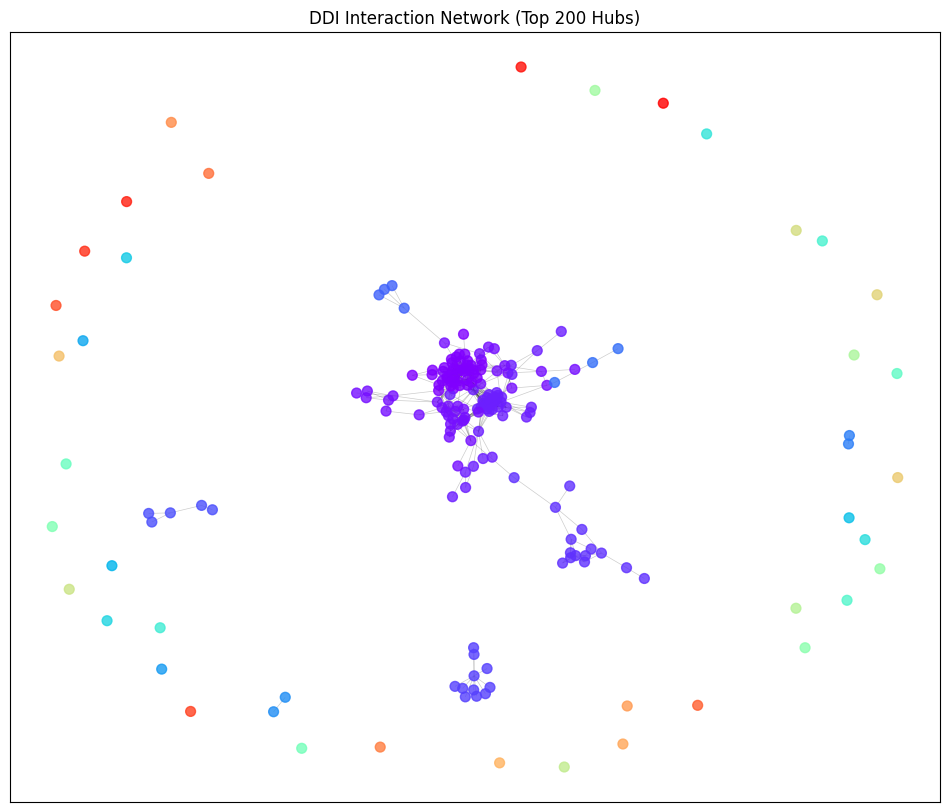

------------------------------
PHASE 4 COMPLETE
Total Execution Time: 29.59 seconds
Outputs saved to: ./out\phase-4
------------------------------


In [23]:
import os, gc, math, time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    import networkx as nx
except ImportError:
    raise ImportError("networkx not installed. Run: pip install networkx")

# Start execution timer
phase4_start_time = time.time()

# ----------------------------
# CONFIG & DIRECTORY SETUP
# ----------------------------
BASE_DIR = r"./out"
PHASE4_DIR = os.path.join(BASE_DIR, "phase-4")
os.makedirs(PHASE4_DIR, exist_ok=True)

# Input from Phase 2/3 outputs
PAIRS_CSV = os.path.join(BASE_DIR, "phase-2", "engineered_features_final.csv")

# Leakage-aware split parameters
TEST_SIZE = 0.20
RANDOM_SEED = 42
CHUNK = 250_000
BETWEENNESS_K = 1000  
TOP_HUBS_VIZ = 200    

def status(msg):
    print(f"\n🚀 {msg}")

def count_rows_fast(path):
    if not os.path.exists(path): return 0
    with open(path, "rb") as f:
        return sum(1 for _ in f) - 1

def edge_is_test(u, v, test_size, seed):
    """Deterministic hash-based split to avoid data leakage"""
    # Use string representations for consistent hashing of alphanumeric IDs
    a, b = (str(u), str(v)) if str(u) < str(v) else (str(v), str(u))
    x = (hash(f"{a}-{b}-{seed}")) & 0xFFFFFFFF
    return (x / 2**32) < test_size

# ----------------------------
# STEP 4.1: Graph Construction (Train-Only)
# ----------------------------
def build_train_graph(pairs_csv):
    status("Step 4.1 — Building Leakage-Aware Training Graph")
    
    total_rows = count_rows_fast(pairs_csv)
    G_train = nx.Graph()
    
    # Load and split
    # Removed the int() conversion to support alphanumeric IDs like 'P00734'
    with tqdm(total=total_rows, desc="Processing Edges", unit="row") as pbar:
        for chunk in pd.read_csv(pairs_csv, usecols=["drug_pk", "interactant_id", "target_label"], chunksize=CHUNK):
            positives = chunk[chunk["target_label"] == 1]
            
            for _, row in positives.iterrows():
                # Corrected: Treat IDs as strings to support alphanumeric literals
                u, v = str(row["drug_pk"]), str(row["interactant_id"])
                if not edge_is_test(u, v, TEST_SIZE, RANDOM_SEED):
                    G_train.add_edge(u, v)
            pbar.update(len(chunk))
            
    print(f"Train Graph: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges")
    return G_train

# ----------------------------
# STEP 4.2: Metrics Computation
# ----------------------------
def compute_leakage_safe_metrics(G):
    status("Step 4.2 — Computing Leakage-Safe Graph Metrics")
    nodes = list(G.nodes())
    
    # Fast metrics: Degree and Degree Centrality
    deg = dict(G.degree())
    deg_cent = nx.degree_centrality(G)
    
    print("Computing clustering coefficients...")
    clustering = nx.clustering(G)
    
    print(f"Computing approx betweenness (k={BETWEENNESS_K})...")
    betweenness = nx.betweenness_centrality(G, k=min(BETWEENNESS_K, len(nodes)), seed=RANDOM_SEED)
    
    metrics_df = pd.DataFrame({
        "node_id": nodes,
        "train_degree": [deg.get(n, 0) for n in nodes],
        "train_deg_centrality": [deg_cent.get(n, 0) for n in nodes],
        "train_clustering": [clustering.get(n, 0) for n in nodes],
        "train_betweenness": [betweenness.get(n, 0) for n in nodes]
    })
    
    metrics_df.to_csv(os.path.join(PHASE4_DIR, "step42_graph_metrics.csv"), index=False)
    return metrics_df

# ----------------------------
# STEP 4.3: Visualization & Community Detection
# ----------------------------
def visualize_ddi_network(G, metrics):
    status("Step 4.3 — Visualization & Community Structure")
    
    # Sample top hubs for clear visualization
    top_nodes = metrics.sort_values("train_degree", ascending=False)["node_id"].head(TOP_HUBS_VIZ)
    H = G.subgraph(top_nodes)
    
    from networkx.algorithms.community import greedy_modularity_communities
    communities = list(greedy_modularity_communities(H))
    
    color_map = {}
    for i, comm in enumerate(communities):
        for node in comm:
            color_map[node] = i

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(H, seed=RANDOM_SEED)
    colors = [color_map.get(node, 0) for node in H.nodes()]
    
    nx.draw_networkx_nodes(H, pos, node_size=50, node_color=colors, cmap=plt.cm.rainbow, alpha=0.8)
    nx.draw_networkx_edges(H, pos, alpha=0.2, width=0.5)
    
    plt.title(f"DDI Interaction Network (Top {TOP_HUBS_VIZ} Hubs)")
    plt.savefig(os.path.join(PHASE4_DIR, "step43_network_viz.png"), dpi=300)
    plt.show()

# EXECUTION
G_train = build_train_graph(PAIRS_CSV)
metrics_df = compute_leakage_safe_metrics(G_train)
visualize_ddi_network(G_train, metrics_df)

end_time = time.time()
print("-" * 30)
print(f"PHASE 4 COMPLETE")
print(f"Total Execution Time: {end_time - phase4_start_time:.2f} seconds")
print(f"Outputs saved to: {PHASE4_DIR}")
print("-" * 30)